# Moth Scanner Demo
*This notebook visualizes the results of trained models (detector and classifier) for the moth scanner presented in the following [paper]*.

[paper]: https://pub.inf-cv.uni-jena.de/search/Korsch21_DLP

## Installation

We suggest using [miniconda]. All required libraries are listed in the `requirements.txt` and can be installed with `pip`:

```bash
conda create -n scanner_demo python~=3.8.0
conda activate scanner_demo
pip install -r requirements.txt
```

[miniconda]: https://docs.conda.io/en/latest/miniconda.html

## Data and Model Weights

### Data
The [EU-Moths][1] dataset can be downloaded from the given URL. In this notebook, we assume that the uncropped version of it is located under `/home/korsch/Data/datasets/moths/eu_moths/uncropped/ORIGINAL`. Set the `root` attribute of the `Args` class accordingly when you create an instance of it to match the location of your dataset. Please consult this [GitHub repository][2] to get more information about the [MCC] dataset.

### Model Weights

Download the weights of the detector and the classifier and move them in the same directory as the jupyter notebook:
* [Classifier] (~ 84.7 MB)
* [Detector] (~ 78.8 MB)

*Password for both downloads: `Moth_Scanner`*

[1]: https://www.inf-cv.uni-jena.de/eu_moths_dataset
[2]: https://github.com/kimbjerge/MCC-trap/
[MCC]: https://github.com/kimbjerge/MCC-trap/tree/master/data
[Classifier]: http://ammod.inf-cv.uni-jena.de/sharing/U5wV185GT
[Detector]: http://ammod.inf-cv.uni-jena.de/sharing/gpqKZNVEp

In [1]:
import abc
import chainer
import numpy as np
import pyaml
import os

from chainer import functions as F
from chainer.serializers import load_npz
from chainer.datasets import TransformDataset
from chainer.backends import cuda
from chainercv import transforms as tr
from chainercv import visualizations as vis
from chainercv.links.model.ssd import SSD300

from dataclasses import dataclass
from pathlib import Path
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

from cvmodelz.models import ModelFactory

In [2]:
@dataclass
class Args:
    def __str__(self):
        return pyaml.dump(dict(Arguments=self.__dict__), sort_dicts=False)
    
    # data options
    root:                      str  = ""
    
    # classifier model options
    clf_model_type:            str  = "cvmodelz.InceptionV3" # used model with pre-trained weights
    clf_weights:               str  = "classifier.npz"
        
    n_classes:                 int  = 200
    class_names:               str  = "class_names.txt"

    # detection model options
    det_model_type:            str  = "ssd" # used detector with pre-trained weights
    det_weights:               str  = "detector.npz" 
    det_input_size:            int  = 300
    
    # -1 = CPU, <int> = GPU ID (works only if you installed cupy)
    gpu:                       int  = -1
    extensions:                tuple = (".jpg", ".png", ".jpeg")
    


In [3]:
class BaseTransform:
    def __init__(self, size: int, *args, **kwargs):
        super().__init__()
        self._size = size
    
    @property
    def size(self):
        return (self._size, self._size)
    
    
class BaseWrapper(abc.ABC):
    
    def __init__(self, model: chainer.Chain, transform: BaseTransform):
        super().__init__()
        
        self.model = model
        self.transform = transform
    
    def __call__(self, *inputs):
        orig, X, *_ = self.transform(inputs)
        # either numpy or cupy
        xp = self.model.xp
        
        
        # reshape X from CxHxW to 1xCxHxW, before calling the model
        output = self.model(xp.array(X[None]))
        return self.output_transform(output)

    @abc.abstractmethod
    def output_transform(self, output):
        return output


# Detector 

In [4]:
_unpack = chainer.as_array


class DetectorTransform(BaseTransform):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __call__(self, data):
        orig, *_ = data
        
        im = tr.scale(orig, self._size, fit_short=True)
        im = tr.center_crop(im, self.size)
        
        return [orig, im] + _
    
class DetectorWrapper(BaseWrapper):
    
    def decode(self, loc, conf):
        return self.model.coder.decode(
            _unpack(loc), 
            _unpack(conf),
            self.model.nms_thresh,
            self.model.score_thresh)

    
    def output_transform(self, output):
        locs, confs = output
        bboxes, labels, scores = [], [], []

        for loc, conf in zip(_unpack(locs), _unpack(confs)):
            bbox, label, score = self.decode(loc, conf)
            bboxes.append(cuda.to_cpu(bbox))
            labels.append(cuda.to_cpu(label))
            scores.append(cuda.to_cpu(score))

        return bboxes, labels, scores

def init_detector(args: Args):
    model = SSD300(n_fg_class=1)
    model.use_preset("evaluate")
    model.nms_thresh = 0.25
    
    load_npz(args.det_weights, model, path="model/", strict=True)
    
    transform = DetectorTransform(size=args.det_input_size)
    
    return DetectorWrapper(model, transform)


def project_back_bbox(bboxes, orig, size=300):
    _orig = orig.transpose(2, 0, 1)
    C, H, W = _orig.shape
    h = w = size

    size = min(H, W)
    _, params = tr.center_crop(_orig, (size, size), return_param=True)

    x_offset = params["x_slice"].start
    y_offset = params["y_slice"].start

    bboxes = tr.resize_bbox(bboxes, (h,w), (size, size))

    bboxes[:, 0] += y_offset
    bboxes[:, 1] += x_offset
    bboxes[:, 2] += y_offset
    bboxes[:, 3] += x_offset

    return bboxes


# Classifier

In [5]:
class ClassifierTransform(BaseTransform):
    
    def __init__(self, prepare_func, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._prepare = prepare_func
        self._kwargs = kwargs
    
    def __call__(self, data):
        orig, *_ = data 
        im = self._prepare(orig.transpose(1, 2, 0), **self._kwargs)
        im = tr.center_crop(im, self.size)
        return [orig, im] + _

class ClassifierWrapper(BaseWrapper):
    
    def output_transform(self, output):
        output.to_cpu()
        return output
#         return F.argmax(output, axis=1)

def init_classifier(args: Args):
    
    model = ModelFactory.new(args.clf_model_type)
    model.load_for_inference(args.clf_weights, n_classes=args.n_classes, path="model/", strict=True)
    
    transform = ClassifierTransform(model.meta.prepare_func, 
                                    model.meta.input_size, 
                                    keep_ratio=True, 
                                    swap_channels=False,
                                   )
    
    return ClassifierWrapper(model, transform)

# Dataset

In [6]:
def _is_image(imname, extensions):
    return Path(imname).suffix.lower() in extensions

def new_dataset(args: Args):
    root = Path(args.root)
    
    if (root / "images.txt").exists():
        paths = str(root / "images.txt")
        imroot = root / "images"
        
    else:
        paths = []
        for path, folders, filenames in os.walk(root):
            paths.extend([Path(path, fname) for fname in filenames if _is_image(fname, args.extensions)])
        
        imroot = root
        paths = [p.relative_to(root) for p in paths]
    
    return chainer.datasets.ImageDataset(paths, imroot, dtype=np.float32)
        

# Detection and Classification Pipeline

In [7]:
def gpu_config(args: Args, clf: BaseWrapper, det: BaseWrapper):
    gpu = args.gpu
    
    if gpu < 0:
        # CPU mode
        return

    device = cuda.get_device_from_id(gpu)
    device.use()
    
    clf.model.to_device(device)
    det.model.to_device(device)

def show_detections(im, bboxes, labels, label_names):
    assert im.shape[-1] == 3, "im must be in HWC format!"
    
    fig, ax = plt.subplots(figsize=(16,9))
    
    # get the best label
    labels = np.array(labels)[:, 0]
    vis.vis_bbox(im.transpose(2,0,1), bboxes, labels, label_names=label_names, ax=ax)
    
    plt.show()
    plt.close()

def square_crop(im, bbox):
    y0, x0, y1, x1 = bbox
    w, h = x1 - x0, y1 - y0
    size = max([w, h])

    dw, dh = (size - w) / 2, (size - h) / 2
    y0, y1 = max(int(y0 - dh), 0), int(y0 - dh + size)
    x0, x1 = max(int(x0 - dw), 0), int(x0 - dw + size)
    return im[:, y0:y1, x0:x1]
    
    
def classify_crops(im, bboxes, clf, topk=5):
    assert im.shape[0] == 3, "im must be in CHW format!"
    
    res = []
    for bbox in bboxes:
        crop = square_crop(im, bbox)
        
        logits = _unpack(clf(crop))[0]
        res.append(np.argsort(-logits)[:topk])
        
    return res
    
def main(args: Args):
    data = new_dataset(args)
    
    print(f"Found {len(data)} images in \"{args.root}\"")
    
    clf = init_classifier(args)
    det = init_detector(args)
    
    class_names = np.loadtxt(args.class_names, dtype=str)
    
    gpu_config(args, clf, det)
    
    idxs = np.random.choice(len(data), size=10, replace=False)
    
    for i in tqdm(idxs):
        im = data[i]
        orig = im.transpose(1,2,0).astype(np.uint8)
        
        _bboxes, _, _ = det(im)
        bboxes = project_back_bbox(_bboxes[0], orig, size=args.det_input_size)
        predictions = classify_crops(im, bboxes, clf)

        show_detections(orig, bboxes, predictions, class_names)
            
    return
    

Arguments:
  root: /home/korsch/Data/datasets/moths/eu_moths/uncropped/ORIGINAL/images
  clf_model_type: cvmodelz.InceptionV3
  clf_weights: classifier.npz
  n_classes: 200
  class_names: class_names.txt
  det_model_type: ssd
  det_weights: detector.npz
  det_input_size: 300
  gpu: -1
  extensions:
    - .jpg
    - .png
    - .jpeg

Found 2205 images in "/home/korsch/Data/datasets/moths/eu_moths/uncropped/ORIGINAL/images"


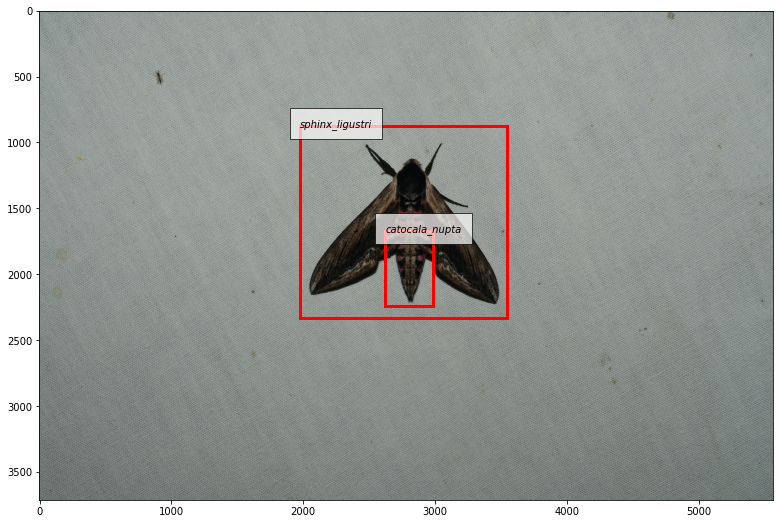

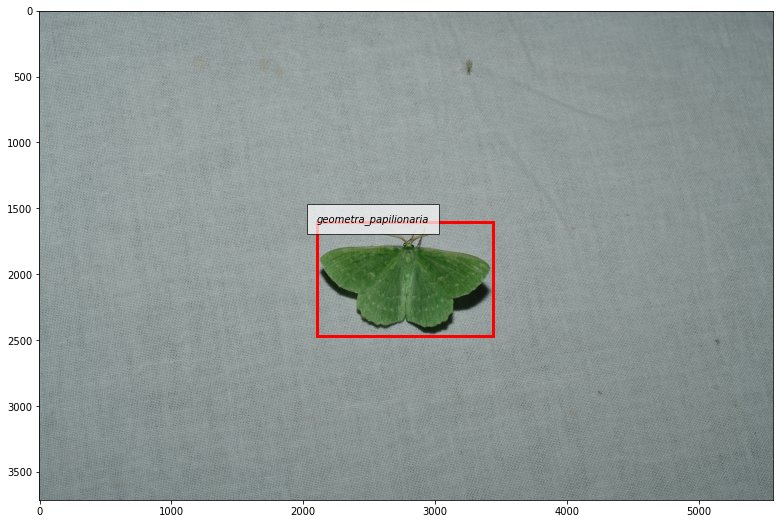

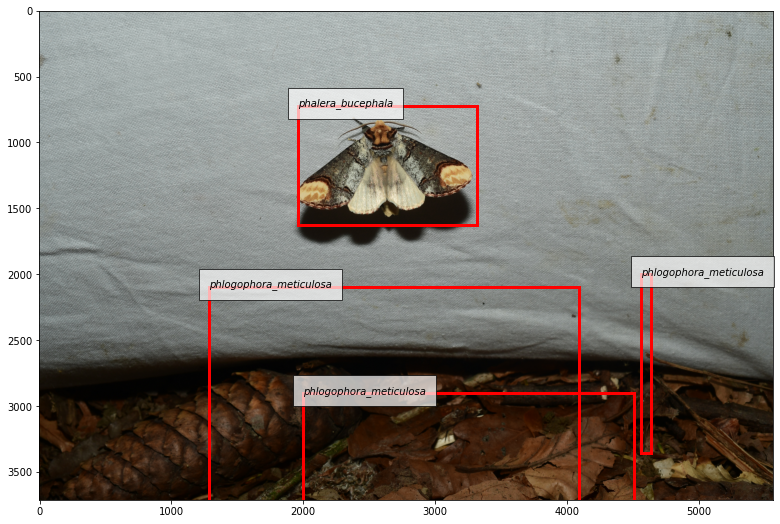

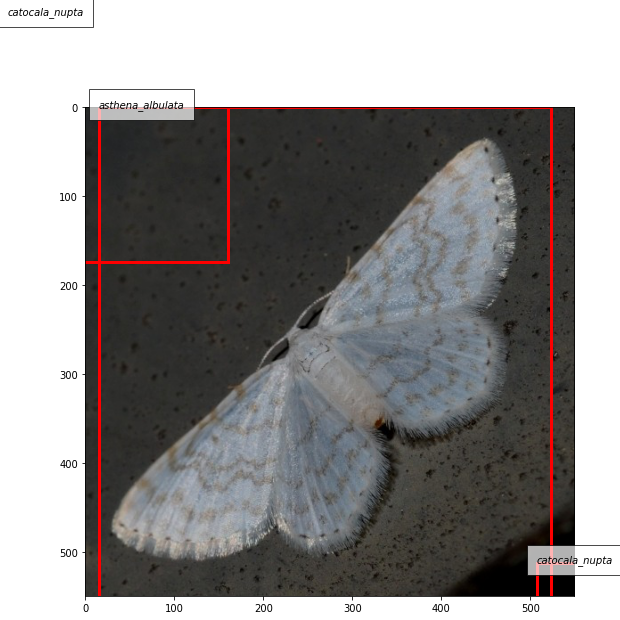

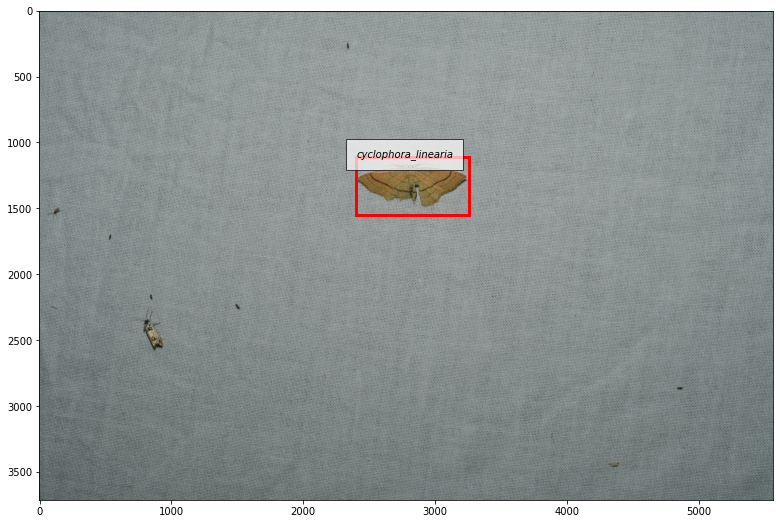

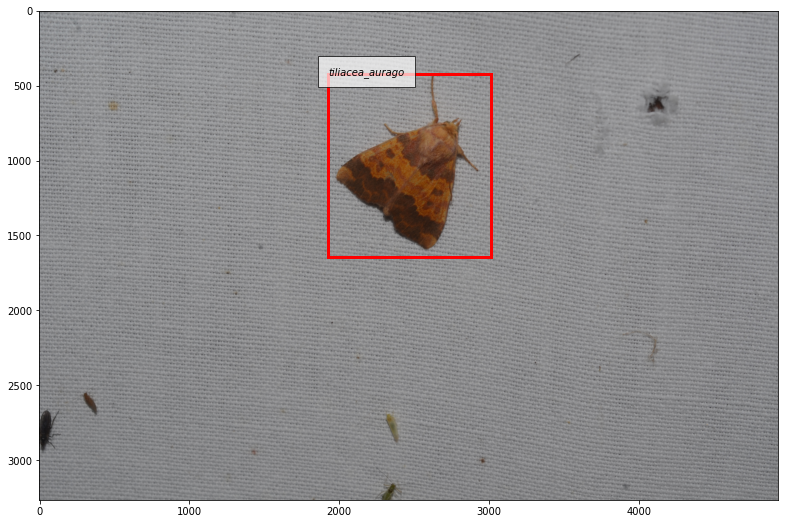

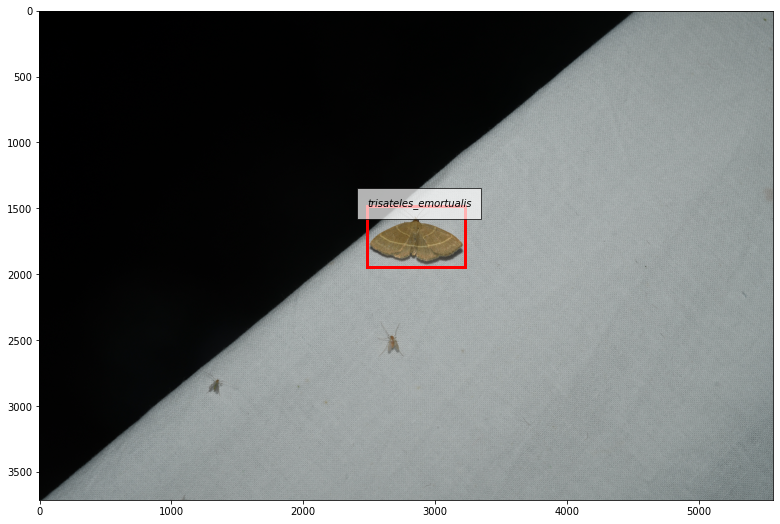

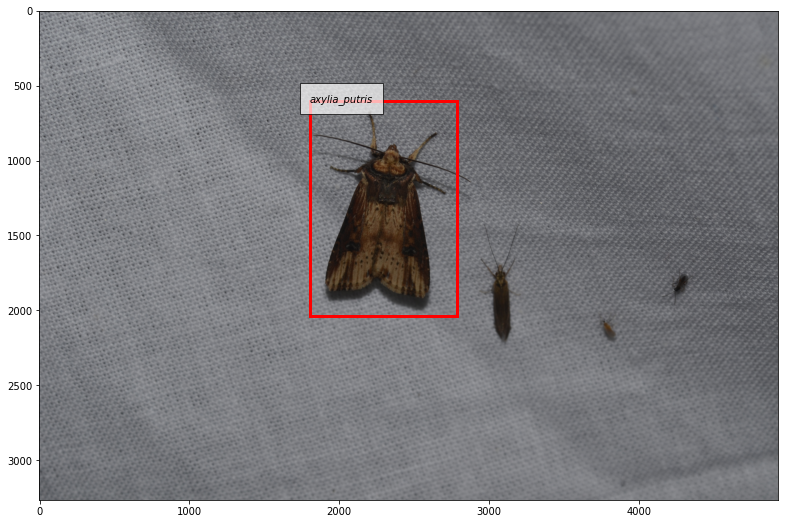

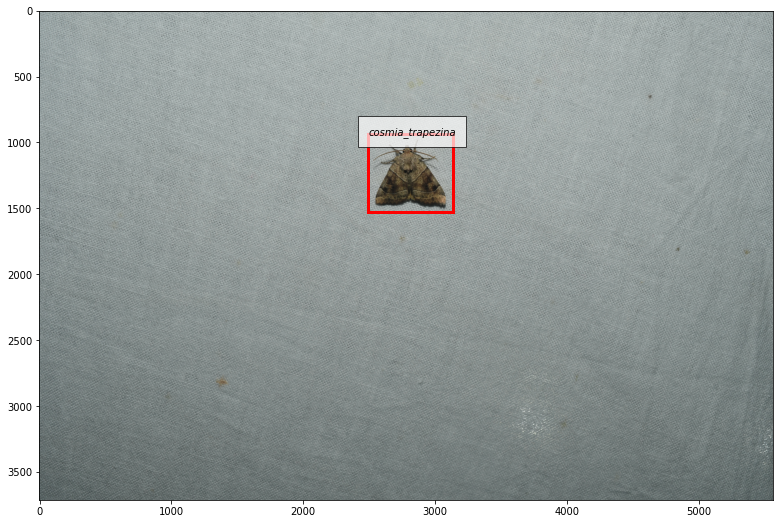

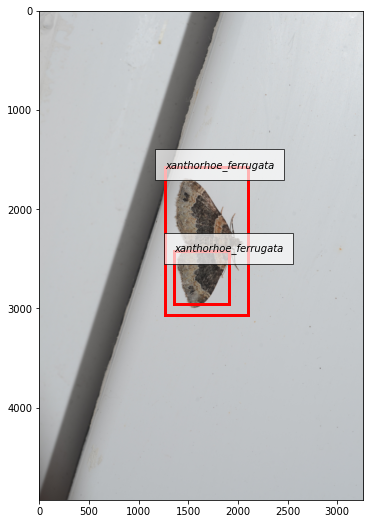

In [8]:
DATA_ROOT = Path("/home/korsch/Data/datasets/moths")

EU_MOTHS = "eu_moths/uncropped/ORIGINAL/images"
MCC_MOTHS = "MCC"

args = Args(
    root = DATA_ROOT / EU_MOTHS,
)
print(args)

with chainer.using_config("train", False), chainer.no_backprop_mode():
    main(args)